# Image Classification using EmuCore
#### Device: EmuCore


## Introduction

In what follows, We present an image classification model built using using QCi's EmuCore technology. 

The dataset consists of 70,000 images of handwritten digits 0-9; 60,000 samples are used for training and the remaining 10,000 images are kept for testing. Each sample is a 28 x 28 pixel image.

The images are serialized in one of the two spatial directions and sent through EmuCore. The output is an enriched dataset which is then used to train a simple linear model.

## Get train and test datasets

We use the **mnist** package from __tensorflow__ to import training data. 

In [32]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


### Plot some of the samples

We plot the first few images in training data,

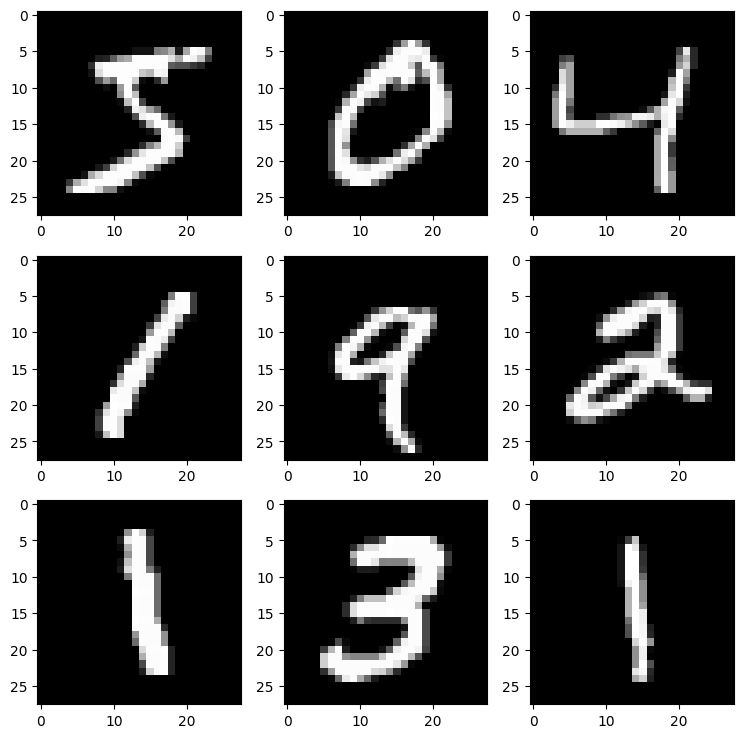

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap("gray"))

plt.show()

And in the testing data,

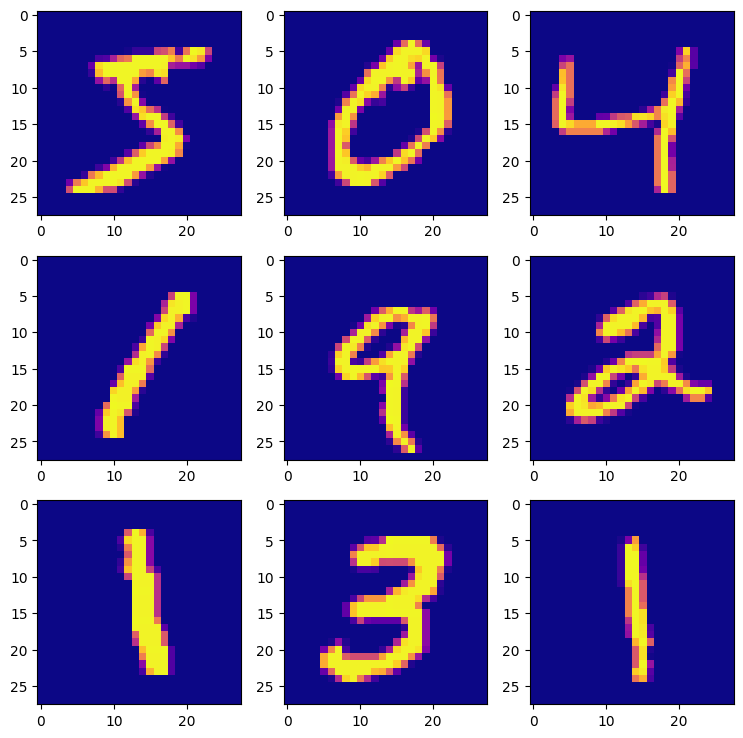

In [34]:
plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap("plasma"))
    
plt.show()

### Normalize data

As each image is 28 by 28 pixels, each sample in the data consists of a 28 by 28 matrix. The elements of the matrix are integers between 0 and 255, each representing one of the 256 colors. We can normalize values to a 0-1 range. This normalization improves the behavior of the reservoir.

In [35]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

### Flatten data

We should now **flatten** in one of the two spatial directions. We have tested with both directions and the results are nearly identical.

In [36]:
#x_train = np.swapaxes(x_train, 1, 2)
#x_test = np.swapaxes(x_test, 1, 2)

x_train_flat = x_train.reshape((x_train.shape[0], 28 * 28))
x_test_flat = x_test.reshape((x_test.shape[0], 28 * 28))

print("Flat x_train shape:", x_train_flat.shape)
print("Flat x_test shape:", x_test_flat.shape)

Flat x_train shape: (60000, 784)
Flat x_test shape: (10000, 784)


We can plot the first few flattened samples,

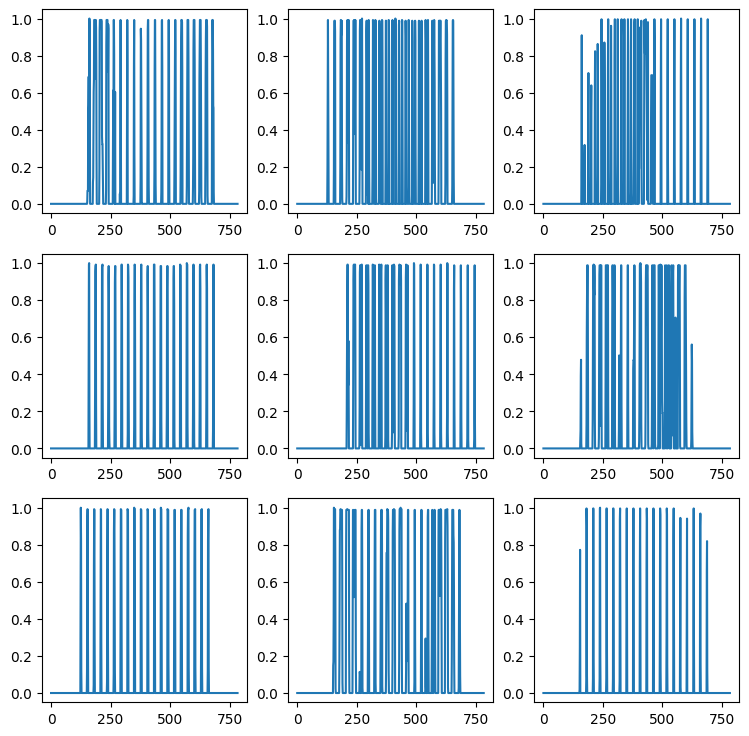

In [37]:
plt.figure(figsize = (9,9))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.plot(x_train_flat[i].reshape(784,1))
    
plt.show()

## Run the dataset through EmuCore

We now push the flattened training and testing data through the reservoir.

In [42]:
from emucore_direct.client import EmuCoreClient

IP_ADDR = "172.22.19.49" 
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 2500
NUM_TAPS = 2500
FEATURE_SCALING = 0.1
DENSITY = 1.0

# Instantiate an EmuCore instance
client = EmuCoreClient(ip_addr=IP_ADDR)

# A a lock id and reset the device
lock_id, start, end = client.wait_for_lock()
client.reservoir_reset(lock_id=lock_id)

# Configure
client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

# Push data through reservoir
resp_train, train_max_scale_val, train_wgts = client.process_all_data(
    input_data=x_train_flat,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

resp_test, test_max_scale_val, test_wgts = client.process_all_data(
    input_data=x_test_flat,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
)

# Release the lock
client.release_lock(lock_id=lock_id)

print("Training response shape:", resp_train.shape)
print("Testing response shape:", resp_test.shape)

Training response shape: (60000, 2500)
Testing response shape: (10000, 2500)


## Build a linear model

We should now build a linear model based on the responses from the reservoir. As each label (from 0 to 9) represents a category of digits, the labels are converted to categorical values; each label is converted to an array with one element set to 1 and the other elements set to -1.

For example, the label "1" is converted to,

$[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1]$

and the label "5" is converted to,

$[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1]$

In [43]:
import numpy as np

def to_categorical(y, num_classes=None, dtype="float32"):

    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
        
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    
    return categorical

y_train_cat = []
for digit in y_train:
    cat_digit = 2 * to_categorical(digit, num_classes=10) - 1
    y_train_cat.append(cat_digit)
    
y_train_cat = np.array(y_train_cat)

y_test_cat = []
for digit in y_test:
    cat_digit = 2 * to_categorical(digit, num_classes=10) - 1
    y_test_cat.append(cat_digit)
    
y_test_cat = np.array(y_test_cat)

print("Categorical y_train.shape:", y_train_cat.shape)
print("Categorical y_test.shape:", y_test_cat.shape)

Categorical y_train.shape: (60000, 10)
Categorical y_test.shape: (10000, 10)


### Train a linear model

We can now build a simple linear model,

In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

model.fit(resp_train, y_train_cat)

print("R2 = ", model.score(resp_train, y_train_cat))

R2 =  0.6806182222229208


### Calculate classification success rates

We can calculate the success rates of classifier on training and testing data,

In [45]:
from sklearn.metrics import accuracy_score

y_train_prd = model.predict(resp_train)
y_test_prd = model.predict(resp_test)

def from_categorical(y_cat):
    y = []
    for i in range(y_cat.shape[0]):
        y.append(np.argmax(y_cat[i]))
        
    return np.array(y)
    
y_train_prd = from_categorical(y_train_prd)
y_test_prd = from_categorical(y_test_prd)

print(
    "Success rate on train data: %0.3f" % (
        accuracy_score(y_train, y_train_prd)
    )
)
   
print(
    "Success rate on test data: %0.3f" % (
        accuracy_score(y_test, y_test_prd)
    )
)

Success rate on train data: 0.919
Success rate on test data: 0.903


## Conclusion
QCi's EmuCore reservoir technoloy was used to build an image classification model using the MNIST digit dataset. In this approach, images are flattened in one of the two spatial dimensions and are passed through EmuCore. A linear model is then trained using the output of EmuCore. The classification model yields a success rate of about 91\% on both training and testing data. 